In [137]:
import csv

import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42


In [138]:
is_spelling_training = False

# Especificando cada caminho

In [139]:
folder_name = "spelling_keypoint_classifier" if is_spelling_training else "sign_keypoint_classifier"

dataset = f'model/{folder_name}/keypoint.csv'
model_save_path = f'model/{folder_name}/keypoint_classifier.keras'

# Número de CM's Classificadas

In [140]:
with open(f'model/{folder_name}/keypoint_classifier_label.csv',
        encoding='utf-8-sig') as f:
    NUM_CLASSES = sum(1 for row in csv.reader(f))

# Carregar dados de aprendizagem

In [141]:
X_dataset = np.loadtxt(
    dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [142]:
y_dataset = np.loadtxt(
    dataset, delimiter=',', dtype='int32', usecols=(0))

In [143]:
X_train, X_test, y_train, y_test = train_test_split(
    X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Construindo modelo

In [144]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [145]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_12 (Dropout)            │ (None, 42)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 20)             │           860 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 10)             │           210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 8)              │            88 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,158 (4.52 KB)

 Trainable params: 1,158 (4.52 KB)

 Non-trainable params: 0 (0.00 B)

In [146]:
# Callback de ponto de verificação do modelo
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback para interrupção antecipada
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [147]:
# Compilação do modelo
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Treinamento do Modelo

In [148]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
166/176 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1996 - loss: 2.0536
Epoch 1: saving model to model/sign_keypoint_classifier/keypoint_classifier.keras
176/176 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.2046 - loss: 2.0436 - val_accuracy: 0.6467 - val_loss: 1.4263
Epoch 2/1000
121/176 ━━━━━━━━━━━━━━━━━━━━ 0s 842us/step - accuracy: 0.4376 - loss: 1.5254
Epoch 2: saving model to model/sign_keypoint_classifier/keypoint_classifier.keras
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4486 - loss: 1.4945 - val_accuracy: 0.8593 - val_loss: 0.9050
Epoch 3/1000
164/176 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5753 - loss: 1.1769
Epoch 3: saving model to model/sign_keypoint_classifier/keypoint_classifier.keras
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5768 - loss: 1.1724 - val_accuracy: 0.9392 - val_loss: 0.6342
Epoch 4/1000
163/176 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6503 - loss: 0.9848
Epoch 4: saving model to model/sign_keypoint_clas

In [149]:
# Avaliação do modelo
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=256)

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9124 - loss: 0.3336 


In [150]:
# Carregando um modelo salvo
model = tf.keras.models.load_model(model_save_path)

In [151]:
# Teste de raciocínio
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
[1.0461518e-01 7.4925337e-09 9.6280068e-08 8.6605155e-01 1.3996083e-02
 3.8474272e-03 5.1659363e-04 1.0973097e-02]
3


# Matriz de confusão

235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 638us/step


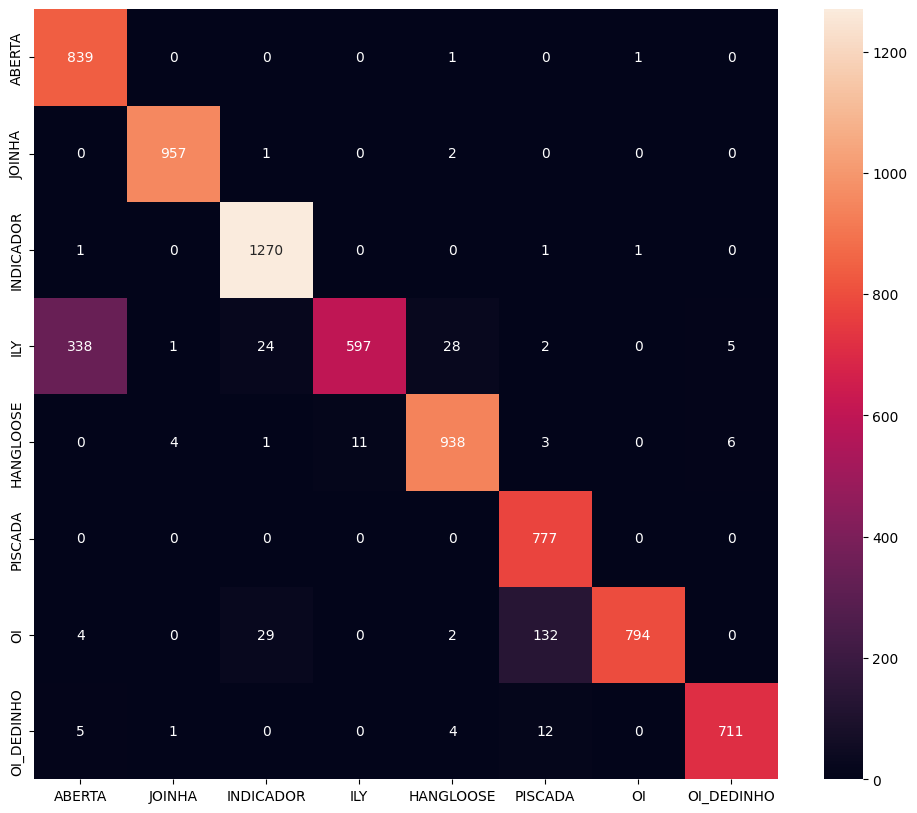

Classification Report
              precision    recall  f1-score   support

      ABERTA       0.71      1.00      0.83       841
      JOINHA       0.99      1.00      1.00       960
   INDICADOR       0.96      1.00      0.98      1273
         ILY       0.98      0.60      0.74       995
   HANGLOOSE       0.96      0.97      0.97       963
     PISCADA       0.84      1.00      0.91       777
          OI       1.00      0.83      0.90       961
  OI_DEDINHO       0.98      0.97      0.98       733

    accuracy                           0.92      7503
   macro avg       0.93      0.92      0.91      7503
weighted avg       0.93      0.92      0.91      7503



In [152]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    with open(f'model/{folder_name}/keypoint_classifier_label.csv',
            encoding='utf-8-sig') as f:
        keypoint_classifier_labels = csv.reader(f)
        keypoint_classifier_labels = [
            row[0] for row in keypoint_classifier_labels
        ]
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    labels = [keypoint_classifier_labels[i] for i in sorted(list(set(y_true)))]
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(12, 10))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred, target_names=labels))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Converter para tensorflow lite

In [153]:
# Salvar como modelo apenas para inferência
model.save(model_save_path, include_optimizer=False)
model = tf.keras.models.load_model(model_save_path)

In [154]:
# Transforme o modelo (quantizar)
tflite_save_path = f'model/{folder_name}/keypoint_classifier.tflite'

converter = tf.lite.TFLiteConverter.from_keras_model(model)  # converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\ARTHUR~1\AppData\Local\Temp\tmppn8skz5l\assets


INFO:tensorflow:Assets written to: C:\Users\ARTHUR~1\AppData\Local\Temp\tmppn8skz5l\assets


Saved artifact at 'C:\Users\ARTHUR~1\AppData\Local\Temp\tmppn8skz5l'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 42), dtype=tf.float32, name='input_layer_6')
Output Type:
  TensorSpec(shape=(None, 8), dtype=tf.float32, name=None)
Captures:
  1570384125136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1570384124560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1570384125328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1570384126672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1570384126480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1570384127440: TensorSpec(shape=(), dtype=tf.resource, name=None)


6732

# Teste de raciocínio

In [155]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [156]:
# Obtenha tensor de entrada/saída
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [157]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [158]:
%%time
# Implementação de inferência
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 4.06 ms


In [159]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[1.0461525e-01 7.4925186e-09 9.6279884e-08 8.6605155e-01 1.3996090e-02
 3.8474272e-03 5.1659328e-04 1.0973097e-02]
3
